In [1]:
import pandas as pd
import torch
from torch import nn
from torch.autograd import Variable
from time import time
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv('train1.csv')
# df2 = pd.read_csv('testAll.csv')

df = pd.read_csv('ml-100k.csv')
print(len(df))
df.head()

100000


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
class RatingDataset(data.Dataset):
    def __init__(self, users, items, ratings):
        self.users = users 
        self.items =items
        self.rating = ratings
    
    def __len__(self):
        return len(self.rating)
    
    def __getitem__(self, idx):
        return torch.tensor(self.users[idx]),torch.tensor(self.items[idx]), torch.tensor(self.rating[idx])  

In [4]:
# load data

# train = RatingDataset(df['userId']-1, df['movieId']-1, df['rating']*1.0)
# test = RatingDataset(df2['userId']-1, df2['movieId']-1, df2['rating']*1.0)

data_size = len(df['rating'])
train_size = round(data_size*0.8)
dataset = RatingDataset(df['userId']-1, df['movieId']-1, df['rating']*1.0)
train, test = data.random_split(dataset, [train_size, data_size-train_size])

bg = df['rating'][:train_size].mean()
n_users = df['userId'].max()
n_items = df['movieId'].max()
(n_users, n_items)

(943, 1682)

In [5]:
train_dataloader = data.DataLoader(train, batch_size=100, shuffle=True)
test_dataloader = data.DataLoader(test, batch_size=100)

In [6]:
class GMF(nn.Module):
    def __init__(self, n_users, n_items, bg, n_factors=40):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.bg = bg
        self.n_factors = n_factors
        
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.user_biases = nn.Embedding(n_users, 1)
        self.item_biases = nn.Embedding(n_items, 1)
        
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

#         self.output = nn.Linear(in_features=self.n_factors, out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, user, item):
        ratings = self.user_biases(user) + self.item_biases(item)+ self.bg
        ratings += ((self.user_factors(user) * self.item_factors(item)).sum(dim=1, keepdim=True))
        return ratings.squeeze()
    
#     def forward(self, users, items):
#         user_factors = self.user_factors(users)
#         item_factors = self.item_factors(items)
#         element_product = torch.mul(user_factors, item_factors)
#         ratings = self.output(element_product)
# #         rating = self.logistic(logits)
#         return ratings


In [7]:
class MLP(nn.Module):
    def __init__(self, n_users, n_items, n_factors=8,layers =[16,64,32,16,8]):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors

        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.output = nn.Linear(in_features=layers[-1], out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, users, items):
        user_factors = self.user_factors(users)
        item_factors = self.item_factors(items)
        vector = torch.cat([user_factors, item_factors], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        ratings = self.output(vector)
#         rating = self.logistic(logits)
        return ratings.squeeze()

In [8]:
class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, n_factors_mf=50,n_factors_mlp=8,layers =[16,64,32,16,8]):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors_mf = n_factors_mf
        self.n_factors_mlp = n_factors_mlp
        
        self.user_factor_mlp = nn.Embedding(n_users, n_factors_mlp)
        self.item_factor_mlp = nn.Embedding(n_items, n_factors_mlp)
        self.user_factor_mf = nn.Embedding(n_users, n_factors_mf)
        self.item_factor_mf = nn.Embedding(n_items, n_factors_mf)
        self.init_weight()
        
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.output = nn.Linear(in_features=layers[-1] + n_factors_mf, out_features=1)
#         self.logistic = torch.nn.Sigmoid()

    def forward(self, users, items):
        dropout = nn.Dropout(p=0.2)
        user_mlp = self.user_factor_mlp(users)
        item_mlp = self.item_factor_mlp(items)
        user_mf = self.user_factor_mf(users)
        item_mf = self.item_factor_mf(items)

        mf_vector = torch.mul(user_mf, item_mf)
        mf_vector = dropout(mf_vector)
        
        mlp_vector = torch.cat([user_mlp, item_mlp], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
        mlp_vector = dropout(mlp_vector)
        
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        ratings = self.output(vector)
#         rating = self.logistic(logits)
        return ratings.squeeze()
    
    def init_weight(self):
        nn.init.xavier_uniform_(self.user_factor_mlp.weight)
        nn.init.xavier_uniform_(self.item_factor_mlp.weight)
        nn.init.xavier_uniform_(self.user_factor_mf.weight)
        nn.init.xavier_uniform_(self.item_factor_mf.weight)

In [9]:
model = NeuMF(n_users, n_items)
# model = GMF(n_users, n_items, bg)
loss_func = nn.MSELoss()
l1_loss = nn.L1Loss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [10]:
start = time()
epoches = 20
L =[]
mae=[]

for epoch in range(epoches):
    l =0.0
    for i,(users, items, ratings) in enumerate(train_dataloader):
        users = Variable(torch.LongTensor(users))
        items = Variable(torch.LongTensor(items))
        ratings = Variable(torch.FloatTensor(ratings.float()))
        
        # Predict and calculate loss for user factor and bias
        prediction = model(users, items)
        
        loss = loss_func(prediction.squeeze(), ratings)    
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        l += loss.item()
    L.append(l)
    
    m = 0.0
    total = 0
    for j, (users, items, ratings) in enumerate(test_dataloader):
        users = Variable(torch.LongTensor(users))
        items = Variable(torch.LongTensor(items))
        ratings = Variable(torch.FloatTensor(ratings.float()))

        prediction = model(users, items)
        m += l1_loss(prediction.round().squeeze(), ratings).item()
        total += ratings.size(0)
    m/=total
#     if len(mae)!=0 and m > mae[-1]: break
    mae.append(m) 
        
print(round((time()-start)/60,2))

2.45


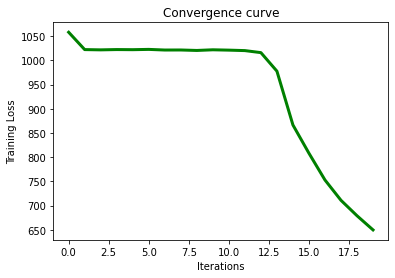

In [11]:
fig1 = plt.figure('Training Loss')
x = range(len(L))
plt.plot(x, L, color='g',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

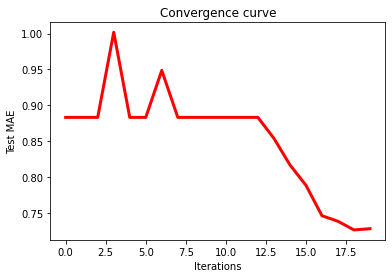

In [12]:
x = range(len(mae))
plt.plot(x, mae, color='r',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('Iterations')
plt.ylabel('Test MAE')
plt.show()

In [13]:
m = 0.0
total = 0
# pred = []
for j, (users, items, ratings) in enumerate(test_dataloader):
    users = Variable(torch.LongTensor(users))
    items = Variable(torch.LongTensor(items))
    ratings = Variable(torch.FloatTensor(ratings.float()))

    prediction = model(users, items)
    m += l1_loss(prediction.round().squeeze(), ratings).item()
    total += ratings.size(0)
#     pred.extend(prediction.tolist())
m/=total
m

0.7307